#Simulating EES with the Iterated Prisoner's Dilemma
This work...

## Requirements
PlantUML for showing uml diagrams

In [16]:
# PlantUML setup
%install_ext https://gist.githubusercontent.com/sberke/7360a4b7aa79aefccbb0/raw/f19a8910c847421977daa7a8c893bb7d77aa78b5/plantuml_magics.py
%load_ext plantuml_magics

import glob
glob.glob(r'./*.jar')

Installed plantuml_magics.py. To use it, type:
  %load_ext plantuml_magics
The plantuml_magics extension is already loaded. To reload it, use:
  %reload_ext plantuml_magics


['./plantuml.jar']

In [50]:
import numpy
import pandas

from abc import ABCMeta
from abc import abstractmethod


In [6]:
from IPython.display import display, HTML

## Prisoner's Dilemma

What is the _**Prisoner's Dilemma**_ (**PD**)
 <table style="width:200px">
  <tr>
    <td></td>
    <td><strong>C</strong></td>
    <td><strong>D</strong></td>
  </tr>
  <tr>
    <td><strong>C</strong></td>
    <td><em>R,R</em></td>
    <td><em>S,T</em></td>
  </tr>
  <tr>
    <td><strong>D</strong></td>
    <td><em>T,S</em></td>
    <td><em>P,P</em></td>
  </tr>
</table> 

##Iterated Prisoner's Dilemma
What is the _**Iterated Prisoner's Dilemma**_ (IPD)

###Axelrod's 1979 tournament


###Axelrod's 1982 tournament

##Modeling

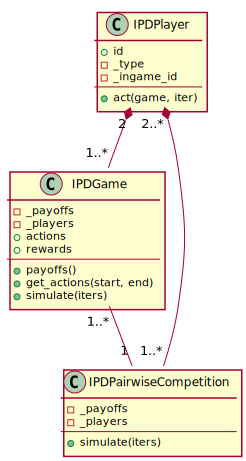

In [40]:
%%plantuml uml/class-diagram-1

@startuml
class IPDPlayer{
    +id
    -_type
    -_ingame_id
    --
    +act(game, iter)
}
class IPDGame{
    -_payoffs
    -_players
    +actions
    +rewards
    --
    +payoffs()
    +get_actions(start, end)
    +simulate(iters)
}
class IPDPairwiseCompetition{
    -_payoffs
    -_players
    --
    +simulate(iters)
}
IPDPlayer "2" *-- "1..*" IPDGame
IPDGame "1..*" -- "1" IPDPairwiseCompetition
IPDPairwiseCompetition "1..*" --* "2..*" IPDPlayer
@enduml 

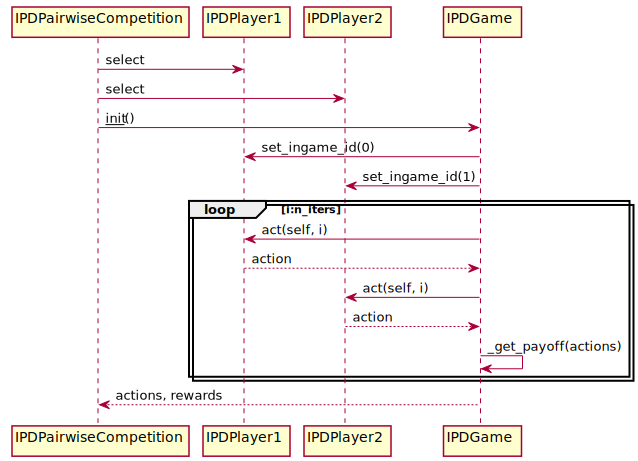

In [41]:
%%plantuml uml/sequence-competition

@startuml
IPDPairwiseCompetition -> IPDPlayer1: select
IPDPairwiseCompetition -> IPDPlayer2: select
IPDPairwiseCompetition -> IPDGame: __init__()
IPDGame -> IPDPlayer1: set_ingame_id(0)
IPDGame -> IPDPlayer2: set_ingame_id(1)    
    loop i:n_iters
        IPDGame -> IPDPlayer1: act(self, i)
        IPDPlayer1 --> IPDGame: action
        IPDGame -> IPDPlayer2: act(self, i)
        IPDPlayer2 --> IPDGame: action
        IPDGame -> IPDGame: _get_payoff(actions)
    end
    IPDGame --> IPDPairwiseCompetition: actions, rewards
@enduml 

##Simulating Player types

  +


In [ ]:
# %load -s IPDGame pd.py
class IPDGame(object):

    """
    Representing a two players Iterated Prisoner's Dilemma game (IPD)
    """

    def __init__(self,
                 players,
                 payoffs,
                 obs_noise=0.0):
        """
        WRITEME
        """
        self._payoffs = payoffs
        self._players = players
        self._n_players = len(players)

        #
        # noise in payoffs as seen by players
        self._noise = obs_noise

        #
        # a game will have a history of actions and rewards when simulated
        self.actions = None
        self.rewards = None
        #
        #

    def _gen_noisy_channel(self):
        return numpy.random.randn(self._payoffs.shape) * self._noise

    def payoffs(self):
        """
        WRITEME
        """
        return self._payoffs  # + self._gen_noisy_channel()

    def get_actions(self, iter_start, iter_end):
        """
        Return the actions for the previous iterates
        """
        # print(iter_start, iter_end)
        return self.actions[:, iter_start:iter_end]

    def _get_payoffs(self, actions):
        """
        Accessing matrix payoffs
        """
        return self._payoffs[[[a] for a in actions]]

    @classmethod
    def build_payoff_matrix(cls, n_players, n_actions):
        """
        For a 2 players game with 2 actions the matrix
        2 x 2 x 2 (n_actions x n_actions x n_players)
        """
        geometry = [n_actions for i in range(n_players)] + [n_players]
        return numpy.zeros(geometry)

    @classmethod
    def repr_action(cls, action):
        """
        0 = 'C' = 'Cooperate'
        1 = 'D' = 'Defect'
        """
        action_str = '*'
        if action == 0:
            action_str = 'C'
        elif action == 1:
            action_str = 'D'

        return action_str

    @classmethod
    def visualize_actions_text(cls, players, actions, rewards):
        """
        WRITEME
        """
        n_iters = actions.shape[1]
        n_players = len(players)

        for p in range(n_players):
            print('\n{0}:'.format(players[p]), end=' ')
            for i in range(n_iters):
                print(IPDGame.repr_action(actions[p, i]), end='')
            print('  [{}]'.format(format(rewards[p].sum())), end='')

    def simulate(self,
                 iters=None,
                 printing=False):
        """
        WRITEME
        """
        if iters is None:
            iters = self._n_iters

        #
        # allocating players rewards and actions for the game
        self.rewards = numpy.zeros((self._n_players, iters))
        self.actions = numpy.zeros((self._n_players, iters), dtype=int)

        for i in range(iters):
            for p_id, p in enumerate(self._players):
                self.actions[p_id, i] = p.act(self, i)
                # print('\t{0}: {1}'.format(p, IPDGameSimulation.repr_action(actions[p.id, i])))
            self.rewards[:, i] = self._get_payoffs(self.actions[:, i])
            # print(self._game.actions)

        #
        # printing
        if printing:
            IPDGame.visualize_actions_text(self._players,
                                           self.actions,
                                           self.rewards)

        return self.actions, self.rewards


In [ ]:
# %load -s IPDPairwiseCompetition pd.py
class IPDPairwiseCompetition(object):

    def __init__(self,
                 players,
                 payoffs,
                 n_iters,
                 obs_noise=0.0):
        """
        WRITEME
        """
        self._n_iters = n_iters
        self._players = players
        self._payoffs = payoffs

        self._noise = obs_noise
        # self.curr_iter = 0
        self._eps = 1e-5

    def simulate(self, n_iters=None, printing=True):
        """
        WRITEME
        """

        if n_iters is None:
            n_iters = self._n_iters

        #
        # allocating stats matrix
        n_players = len(self._players)
        n_games = 0
        scores = numpy.zeros((n_players, n_players))
        #
        # an array for #victories, #draws, #losses
        victories = numpy.zeros((n_players, 3), dtype=int)
        # draws = numpy.zeros(n_players, dtype=int)

        for p_1 in range(n_players):

            player_1 = self._players[p_1]
            player_1.set_ingame_id(0)

            #
            # not playing against itself
            for p_2 in range(p_1 + 1, n_players):

                player_2 = self._players[p_2]
                player_2.set_ingame_id(1)

                n_games += 1
                if printing:
                    print('\n\ngame #{}:'.format(n_games), end='')

                #
                # create a new 2 player ipd game
                game = IPDGame([player_1, player_2],
                               self._payoffs,
                               self._noise)

                #
                # collecting stats
                actions, rewards = game.simulate(n_iters, printing)
                scores[p_1, p_2] = rewards[0, :].sum()
                scores[p_2, p_1] = rewards[1, :].sum()

                n_draws = (numpy.abs(rewards[0, :] - rewards[1, :]) < self._eps).sum()
                p_1_victories = (rewards[0, :] > rewards[1, :]).sum()
                p_2_victories = (rewards[0, :] < rewards[1, :]).sum()

                victories[p_1, 1] += n_draws
                victories[p_2, 1] += n_draws
                victories[p_1, 0] += p_1_victories
                victories[p_2, 0] += p_2_victories
                victories[p_1, 2] += p_2_victories
                victories[p_2, 2] += p_1_victories
                # else:

        if printing:
            IPDPairwiseCompetition.visualize_stats_text(self._players,
                                                        scores,
                                                        victories,
                                                        n_iters)

        #
        # create a pandas dataframe for later reuse
        results = IPDPairwiseCompetition.scores_to_frame(self._players, scores, victories)

        # print('results')
        # print(results)

        return results

    @classmethod
    def scores_to_frame(cls, players, scores, victories):
        """
        WRITEME
        """
        #
        # creating columns
        ids = [p.id for p in players]
        p_types = pandas.Series({p.id: p._type for p in players})
        p_scores = pandas.Series(scores.sum(axis=1), index=ids)
        p_wins = pandas.Series(victories[:, 0], index=ids)
        p_draws = pandas.Series(victories[:, 1], index=ids)
        p_losses = pandas.Series(victories[:, 2], index=ids)

        #
        # composing table
        frame = pandas.DataFrame({'types': p_types,
                                  'scores': p_scores,
                                  'wins': p_wins,
                                  'draws': p_draws,
                                  'losses': p_losses})

        #
        # imposing column order
        frame = frame[['types', 'scores', 'wins', 'draws', 'losses']]

        return frame

    @classmethod
    def visualize_stats_text(cls, players, scores, victories, n_iters):

        n_players = len(players)
        assert scores.shape[0] == n_players
        assert len(victories) == n_players

        print('\n\nScore matrix')
        print(scores)
        print('\nFinal scores')
        print('Player:\tType:\tScore:\t#Wins\t#Draws\t#Losses:')
        for i, p in enumerate(players):
            print('{0}\t{1}\t{2:.4f}\t[{3}\t{4}\t{5}]'.format(p.id,
                                                              p._type.rjust(5),
                                                              scores[i, :].sum() /
                                                              (n_players * n_iters),
                                                              victories[i, 0],
                                                              victories[i, 1],
                                                              victories[i, 2]))


In [ ]:
# %load -s IPDPlayer pd.py
class IPDPlayer(metaclass=ABCMeta):

    """
    WRITEME
    """

    id_counter = 0

    @classmethod
    def reset_id_counter(cls):
        """
        WRITEME
        """
        IPDPlayer.id_counter = 0

    def __init__(self,
                 player_type):
        """
        WRITEME
        """
        #
        # global id
        self.id = IPDPlayer.id_counter
        IPDPlayer.id_counter += 1

        #
        # local (game) id (0 or 1)
        self._ingame_id = None

        self._type = player_type

    def set_ingame_id(self, id):
        """
        WRITEME
        """
        self._ingame_id = id

    @abstractmethod
    def act(self, game, iter):
        """
        WRITEME
        """

    def __repr__(self):
        """
        WRITEME
        """
        type_str = ('({})'.format(self._type)).rjust(6)
        return "player #{0} {1}".format(str(self.id).ljust(4), type_str)


###Periodic Players (I)

###AllD

###AllC

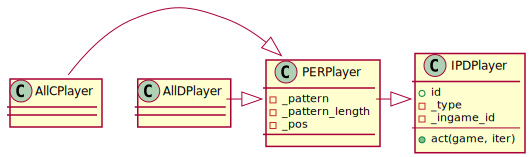

In [56]:
%%plantuml uml/periodic-players-1

@startuml
class IPDPlayer{
    +id
    -_type
    -_ingame_id
    --
    +act(game, iter)
}
class PERPlayer{
    -_pattern
    -_pattern_length
    -_pos
}
PERPlayer -r-|> IPDPlayer
AllCPlayer -r-|> PERPlayer
AllDPlayer -r-|> PERPlayer
@enduml

In [ ]:
# %load -s PERPlayer,AllCPlayer,AllDPlayer pd.py
class PERPlayer(IPDPlayer):

    """
    Periodic Player

    Plays a single pattern with periodicity
    """

    def __init__(self, pattern, player_name=None):
        """
        Pattern is a binary array
        """

        if player_name is None:
            player_name = 'PER'

        IPDPlayer.__init__(self, player_name)

        self._pattern = pattern
        self._pattern_length = len(pattern)
        self._pos = 0

    def act(self, game, iter):
        return self._pattern[iter % self._pattern_length]

    def set_ingame_id(self, id):
        IPDPlayer.set_ingame_id(self, id)
        self._pos = 0

class AllCPlayer(PERPlayer):

    """
    A Player that always cooperates
    """

    def __init__(self):
        """
        WRITEME
        """
        allc_pattern = numpy.array([0])
        PERPlayer.__init__(self, allc_pattern, 'AllC')

    # def act(self, game, iter):
    #     """
    #     Return 'C'
    #     """
    #     return 0

class AllDPlayer(PERPlayer):

    """
    A Player that always defects
    """

    def __init__(self):
        """
        WRITEME
        """
        alld_pattern = numpy.array([1])
        PERPlayer.__init__(self, alld_pattern, 'AllD')

    # def act(self, game, iter):
    #     """
    #     Return 'D'
    #     """
    #     return 1


###Periodic Players (II)

###PDDC

###PCCD

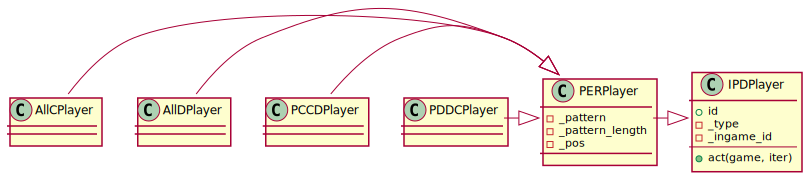

In [57]:
%%plantuml uml/periodic-players-full

@startuml
class IPDPlayer{
    +id
    -_type
    -_ingame_id
    --
    +act(game, iter)
}
class PERPlayer{
    -_pattern
    -_pattern_length
    -_pos
}
PERPlayer -r-|> IPDPlayer
AllCPlayer -r-|> PERPlayer
AllDPlayer -r-|> PERPlayer
PCCDPlayer -r-|> PERPlayer
PDDCPlayer -r-|> PERPlayer
@enduml

In [ ]:
# %load -s PCCDPlayer,PDDCPlayer pd.py
class PCCDPlayer(PERPlayer):

    """
    Periodic Player with pattern CCD
    """

    def __init__(self):
        ccd_pattern = numpy.array([0, 0, 1])
        PERPlayer.__init__(self, ccd_pattern, 'PCCD')

class PDDCPlayer(PERPlayer):

    """
    Periodic Plauer with pattern DDC
    """

    def __init__(self):
        ddc_pattern = numpy.array([1, 1, 0])
        PERPlayer.__init__(self, ddc_pattern, 'PDDC')

# class SHBPlayer(PHBPlayer):

#     """
#     Superrational History Based Player

#     Tries to predict the opponent move based on its history and
#     then tries to maximise the collective payoff. Using exponential smoothing

#     Starts by being cooperative
#     """

#     def __init__(self, history_length=None, alpha=0.6):
#         """
#         WRITEME
#         """
#         HBPlayer.__init__(self, 0, history_length, 'SHB')
#         self._alpha = alpha

#     def act(self, game, iter):
#         #
#         # apply default policy
#         if iter == 0:
#             return self._default_policy

#         #
#         # get history
#         adv_action_history = self._get_history(game, iter)
#         adv_id = 1 - self._ingame_id
#         adv_next = self._predict_next(adv_action_history)

#         strategy = None
#         if adv_id == 1:
#             strategy = game.payoffs()[:, adv_next, :].sum(axis=1)
#         elif adv_id == 0:
#             strategy = game.payoffs()[adv_next, :, :].sum(axis=1)

#         # print('strategy', strategy)
#         # print('payoffs', game.payoffs(),
#         #       adv_action_history, adv_next, self._ingame_id, strategy, numpy.argmax(strategy
#         #                                                                                 ))
#         return numpy.argmax(strategy)


##Where is the emergence?